In [1]:
import numpy as np, h5py
import sys
import os
import tarfile
import time
import gc
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import random
from IPython.display import display, Image
from scipy import ndimage
from skimage.transform import resize
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm, tnrange, tqdm_notebook
from math import log

In [2]:
f = h5py.File(r'/home/hanu/dataset/svhn/f1/train/digitStruct.mat', 'r')

In [8]:
for k in f['digitStruct'].keys():
    print(k)

bbox
name


In [2]:
path = r'/home/hanu/dataset/svhn/f1/'

In [8]:
print(path)

/home/hanu/dataset/svhn/f1/


In [3]:
directory = path

temp_directory = os.path.join(directory,"temp_data")
print(temp_directory)
if not os.path.exists(temp_directory):
    os.makedirs(temp_directory)

synthetic_data_directory = os.path.join(directory,"synthetic_data")
print(synthetic_data_directory)
if not os.path.exists(synthetic_data_directory):
    os.makedirs(synthetic_data_directory)

/home/hanu/dataset/svhn/f1/temp_data
/home/hanu/dataset/svhn/f1/synthetic_data


In [4]:
def merge_two_dicts(x, y):
    '''Given two dicts, merge them into a new dict as a shallow copy.'''
    z = x.copy()
    z.update(y)
    return z

def calculate_total_bbox(digit_bboxes):
    lefts = set()
    tops = set()
    bottoms = set()
    rights = set()
    full_number_list = []
    # some code to populate the sets
    for bbox in digit_bboxes:
        lefts.add(bbox['left'])
        rights.add(bbox['left']+bbox['width'])
        bottoms.add(bbox['top']+bbox['height'])
        tops.add(bbox['top'])
        full_number_list.append(str(int(bbox['label'])))
    full_number = int(''.join(full_number_list))
    return {'left':min(lefts), 'top':min(tops), 'right':max(rights), 'bottom':max(bottoms),'label':full_number}


# Credits to https://github.com/hangyao/ for the below class DigitStructFile, I modified it slightly for my needs

# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s
# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]
        #return [self.getDigitStructure(i) for i in range(10)]

# Return a restructured version of the dataset (one structure by boxed digit).
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                figure['label']  = pictDat[i]['label'][j]
                figure['left']   = pictDat[i]['left'][j]
                figure['top']    = pictDat[i]['top'][j]
                figure['width']  = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        result2 = reduce(lambda d1,d2: merge_two_dicts(d1,d2),
            map(lambda x: {x['filename']: calculate_total_bbox(x['boxes'])},
            result))
        return result2

In [5]:
os.path.exists(os.path.join(temp_directory,"digitStruct.mat"))

False

In [6]:
#"""Create the bounding box picle files if not present"""
def maybe_extract_bounding_box_data():
    if not (os.path.exists(os.path.join(temp_directory,"test_bboxes.pickle")) and os.path.exists(os.path.join(temp_directory,"train_bboxes.pickle"))):
        # Extract the total bounding box data for the test set and save to a Pickle file for use later
        print("Starting to extract the bounding box data for the Test set")
        dsf = DigitStructFile(os.path.join(directory,"test","digitStruct.mat"))
        bbox_data = dsf.getAllDigitStructure_ByDigit()
        print("....The number of bounding box records for the Test set is : "+ str(len(bbox_data)))

        set_filename = os.path.join(temp_directory,"test_bboxes.pickle")
        try:
            with open(set_filename, 'wb') as f:
                pickle.dump(bbox_data, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', set_filename, ':', e)
        print("....pickled complete Test bbox data set")


        # Extract the total bounding box data for the train set and save to a Pickle file for use later
        print("Starting to extract the bounding box data for the Train set")
        dsf = DigitStructFile(os.path.join(directory,"train","digitStruct.mat"))
        bbox_data = dsf.getAllDigitStructure_ByDigit()
        print("....The number of bounding box records for the Train set is : "+ str(len(bbox_data)))

        set_filename = os.path.join(temp_directory,"train_bboxes.pickle")
        try:
            with open(set_filename, 'wb') as f:
                pickle.dump(bbox_data, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', set_filename, ':', e)
        print("....pickled complete Train bbox data set")

    else:
        print("The Digit structs have already been extracted into pickle files for the train and test data")
    return "Done"

In [11]:
maybe_extract_bounding_box_data()

Starting to extract the bounding box data for the Test set
....The number of bounding box records for the Test set is : 13068
....pickled complete Test bbox data set
Starting to extract the bounding box data for the Train set
....The number of bounding box records for the Train set is : 33402
....pickled complete Train bbox data set


'Done'

In [12]:
test_bbox_info_file = open(os.path.join(temp_directory,"test_bboxes.pickle"),'r')
test_bboxes_dict = pickle.load(test_bbox_info_file)

train_bbox_info_file = open(os.path.join(temp_directory,"train_bboxes.pickle"),'r')
train_bboxes_dict = pickle.load(train_bbox_info_file)

In [15]:
test_folder = os.path.join(directory,"test")
train_folder = os.path.join(directory,"train")

In [18]:
image_size = 54  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.
color_channels = 3 # since we are using color images

def crop_and_scale(imagedata,image_filename,bbox_dict):
    image_bbox = bbox_dict[image_filename]
    
    top = int(max(0,image_bbox['top']))
    bottom = int(max(0,image_bbox['bottom']))
    left = int(max(0,image_bbox['left']))
    right = int(max(0,image_bbox['right']))
    
    width = right - left
    height = bottom - top
    
    top = int(max(0,top-(0.15*height)))
    bottom = int(max(0,bottom+(0.15*height)))
    left = int(max(0,left-(0.15*width)))
    right = int(max(0,right+(0.15*width)))
    
    cropped = imagedata[top:bottom,left:right,:]
    scaled = resize(np.ascontiguousarray(cropped),(64,64))
    
    randomTop = random.choice(range(10))
    randomLeft = random.choice(range(10))
    
    final_image = scaled[randomTop:54+randomTop,randomLeft:54+randomLeft,:]
    return final_image


#"""Load the data for a single letter label."""
def load_imagadata(folder, bbox_dict):    
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size, color_channels),
                         dtype=np.float32)
    labels = np.ndarray(shape=(len(image_files)),dtype=np.int)
    image_index = 0
    print("Processing images in the folder: " + folder)
    for image in os.listdir(folder):
        image_file = os.path.join(folder, image)
        try:
            image_data = (ndimage.imread(image_file).astype(float) -  pixel_depth / 2) / pixel_depth
            cropped_and_scaled = crop_and_scale(image_data,image,bbox_dict)
            if cropped_and_scaled.shape != (image_size, image_size, color_channels):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[image_index, :, :,:] = cropped_and_scaled
            labels[image_index] = bbox_dict[image]['label']
            image_index += 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    num_images = image_index
    dataset = dataset[0:num_images, :, :]
    labels = labels[0:num_images]
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset, labels

test_dataset, test_labels = load_imagadata(test_folder,test_bboxes_dict)
train_dataset, train_labels = load_imagadata(train_folder,train_bboxes_dict)

Processing images in the folder: /home/hanu/dataset/svhn/f1/test
('Could not read:', '/home/hanu/dataset/svhn/f1/test/digitStruct.mat', ':', IOError("cannot identify image file '/home/hanu/dataset/svhn/f1/test/digitStruct.mat'",), "- it's ok, skipping.")
('Could not read:', '/home/hanu/dataset/svhn/f1/test/digitStruct.csv', ':', IOError("cannot identify image file '/home/hanu/dataset/svhn/f1/test/digitStruct.csv'",), "- it's ok, skipping.")
('Could not read:', '/home/hanu/dataset/svhn/f1/test/digitStruct_nozeros.dataframe', ':', IOError("cannot identify image file '/home/hanu/dataset/svhn/f1/test/digitStruct_nozeros.dataframe'",), "- it's ok, skipping.")
('Could not read:', '/home/hanu/dataset/svhn/f1/test/digitStruct.dataframe', ':', IOError("cannot identify image file '/home/hanu/dataset/svhn/f1/test/digitStruct.dataframe'",), "- it's ok, skipping.")
('Could not read:', '/home/hanu/dataset/svhn/f1/test/see_bboxes.m', ':', IOError("cannot identify image file '/home/hanu/dataset/svhn/f

34


<function matplotlib.pyplot.show>

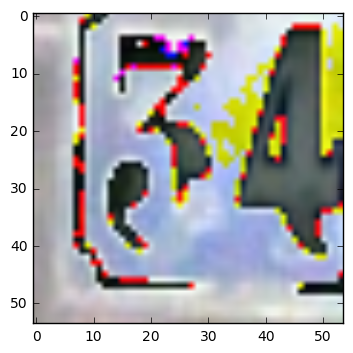

In [19]:
print(train_labels[5])

%matplotlib inline
plt.figure()
plt.imshow(train_dataset[5]);
plt.show

In [21]:
set_filename = os.path.join(temp_directory,"test_dataset.pickle")
try:
    with open(set_filename, 'wb') as f:
        pickle.dump(test_dataset, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', set_filename, ':', e)
print("pickled test dataset")


set_filename = os.path.join(temp_directory,"test_labels.pickle")
try:
    with open(set_filename, 'wb') as f:
        pickle.dump(test_labels, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', set_filename, ':', e)
print("pickled test labels")


set_filename = os.path.join(temp_directory,"train_dataset.pickle")
try:
    with open(set_filename, 'wb') as f:
        pickle.dump(train_dataset, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', set_filename, ':', e)
print("pickled train dataset")


set_filename = os.path.join(temp_directory,"train_labels.pickle")
try:
    with open(set_filename, 'wb') as f:
        pickle.dump(train_labels, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', set_filename, ':', e)
print("pickled train labels")

pickled test dataset
pickled test labels
pickled train dataset
pickled train labels


In [7]:
def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))
        
def calculate_font_size(housenumber):
    if housenumber >= 10000:
        fontsize = 100
    elif housenumber >= 1000:
        fontsize = 150
    elif housenumber >= 100:
        fontsize = 200
    elif housenumber >= 10:
        fontsize = 250
    else:
        fontsize = 300
    return fontsize
        
    
def make_housenumber_sample(housenumber_config):
    fig = plt.figure(figsize=(5.4, 5.4), dpi=10)
    ax = fig.add_subplot(111)
    font = FontProperties()
    font.set_family(housenumber_config['family'])
    font.set_style(housenumber_config['style'])
    ax.text(0.5, 0.5, housenumber_config['random_number'], verticalalignment='center', horizontalalignment='center',
            transform=ax.transAxes, color=housenumber_config['color'], 
            fontsize=calculate_font_size(housenumber_config['random_number']), fontproperties=font, 
            rotation=housenumber_config['rotation'])
    ax.axis([0, 54, 0, 54])
    plt.axis('off')
    #fig.show()
    fig.savefig(housenumber_config['filename'],dpi=10)
    fig.clf()
    plt.close()
    gc.collect()
    

def generate_synthetic_housenumbers(num_samples=1, fileprefix='shn'):
    list_of_hnconfig_tuples = [
                        (
                            synthetic_data_directory + fileprefix + '/' + fileprefix + '-' + str(x),
                            random.choice(['sans-serif','serif']),
                            random.choice(['italic','normal']),
                            random.choice(['orange','red','blue','black','green']),
                            random.choice([0,-20,-10,-5,5,10,20]),
                            random.choice(range(random.choice([100,1000,10000,99999])))+1
                        ) 
                        for x in range(num_samples)
                        ]
    list_of_hnconfig_dicts = map(
                            lambda (filename,family,style,color,rotation,random_number):
                            {'filename':filename,
                             'family':family,
                             'style':style,
                             'color':color,
                             'rotation':rotation,
                             'random_number':random_number
                            },list_of_hnconfig_tuples
                            )
    labels = map(
                lambda (filename,family,style,color,rotation,random_number):
                random_number,
                list_of_hnconfig_tuples
                )

    os.mkdir(synthetic_data_directory+fileprefix)
    print("Generating images....")
    for hnconfig in list_of_hnconfig_dicts:
        #print(hnconfig)
        make_housenumber_sample(hnconfig)
    make_tarfile(synthetic_data_directory+fileprefix+'.tar.gz',synthetic_data_directory+fileprefix)

    set_filename = synthetic_data_directory+fileprefix+'-labels.pickle'
    try:
        with open(set_filename, 'wb') as f:
            pickle.dump(labels, f, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', set_filename, ':', e)

    print("Done generating "+str(num_samples)+" images")

In [8]:
def maybe_generate_synthetic_images():
    """Genetate the synthetic datasets used to initially train the neural network"""
    if not (os.path.exists(os.path.join(synthetic_data_directory,"synthetic_test_set.tar.gz")) and 
          os.path.exists(os.path.join(synthetic_data_directory,"synthetic_train_set.tar.gz"))):
        print("Starting to generate synthetic_test_set...")
        start = time.clock() 
        generate_synthetic_housenumbers(num_samples=15000,fileprefix='synthetic_test_set')
        elapsed = time.clock()
        elapsed = elapsed - start
        print "Time spent was: ", elapsed

        print("Starting to generate synthetic_train_set...")
        start = time.clock() 
        generate_synthetic_housenumbers(num_samples=35000,fileprefix='synthetic_train_set')
        elapsed = time.clock()
        elapsed = elapsed - start
        print "Time spent is: ", elapsed
    else:
        print("The synthetic images have been created already so skipping generation...")
    print("The synthetic images are ready")
    return "synthetic_train_set", "synthetic_test_set"

In [15]:
synthetic_train_folder, synthetic_test_folder =  maybe_generate_synthetic_images()

Starting to generate synthetic_train_set...
Generating images....
Done generating 35000 images
Time spent is:  3335.393244
The synthetic images are ready


In [9]:
synthetic_data_directory

'/home/hanu/dataset/svhn/f1/synthetic_data'

In [10]:
stestlf = open(synthetic_data_directory+'synthetic_test_set-labels.pickle','r')

In [12]:
synthetic_test_labels_list = pickle.load(stestlf)

In [16]:
strainlf = open(synthetic_data_directory+'synthetic_train_set-labels.pickle','r')
synthetic_train_labels_list = pickle.load(strainlf)

In [17]:
synthetic_test_labels_dict = reduce(lambda d1,d2: merge_two_dicts(d1,d2),
                                    map(lambda (x,y):{'synthetic_test_set-'+str(x)+'.png':y},
                                 zip(range(len(synthetic_test_labels_list)),synthetic_test_labels_list)))

synthetic_train_labels_dict = reduce(lambda d1,d2: merge_two_dicts(d1,d2),
                                     map(lambda (x,y):{'synthetic_train_set-'+str(x)+'.png':y},
                                 zip(range(len(synthetic_train_labels_list)),synthetic_train_labels_list)))

In [18]:
image_size = 54  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.
color_channels = 3 # since we are using color images

def load_synthetic_imagadata(folder,label_dict):
  """Load the data for a single letter label."""
  image_files = os.listdir(synthetic_data_directory+folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size, color_channels),
                         dtype=np.float32)
  labels = np.ndarray(shape=(len(image_files)),dtype=np.int)
  image_index = 0
  print("Processing images in the folder: " + folder)
  for image in sorted(os.listdir(synthetic_data_directory+folder)):
    image_file = os.path.join(synthetic_data_directory+folder, image)
    try:
      img = Image.open(image_file).convert("RGB")
      image_data = (np.array(img) - pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size, color_channels):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[image_index, :, :,:] = image_data
      labels[image_index] = label_dict[image]
      image_index += 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset, labels
    
synthetic_test_dataset, synthetic_test_labels = load_synthetic_imagadata(synthetic_test_folder, synthetic_test_labels_dict)
synthetic_train_dataset, synthetic_train_labels= load_synthetic_imagadata(synthetic_train_folder, synthetic_train_labels_dict)

Processing images in the folder: synthetic_test_set
('Full dataset tensor:', (15000, 54, 54, 3))
('Mean:', 0.43560672)
('Standard deviation:', 0.21184637)
Processing images in the folder: synthetic_train_set
('Full dataset tensor:', (35000, 54, 54, 3))
('Mean:', 0.4355773)
('Standard deviation:', 0.21183318)


In [19]:
set_filename = synthetic_data_directory+"synthetic_test_dataset.pickle"
try:
    with open(set_filename, 'wb') as f:
        pickle.dump(synthetic_test_dataset, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', set_filename, ':', e)
print("pickled synthetic test dataset")

set_filename = synthetic_data_directory+"synthetic_test_labels.pickle"
try:
    with open(set_filename, 'wb') as f:
        pickle.dump(synthetic_test_labels, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', set_filename, ':', e)
print("pickled synthetic test labels")

set_filename = synthetic_data_directory+"synthetic_train_dataset.pickle"
try:
    with open(set_filename, 'wb') as f:
        pickle.dump(synthetic_train_dataset, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', set_filename, ':', e)
print("pickled synthetic train dataset")

set_filename = synthetic_data_directory+"synthetic_train_labels.pickle"
try:
    with open(set_filename, 'wb') as f:
        pickle.dump(synthetic_train_labels, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', set_filename, ':', e)
print("pickled synthetic train labels")

pickled synthetic test dataset
pickled synthetic test labels
pickled synthetic train dataset
pickled synthetic train labels


146


<function matplotlib.pyplot.show>

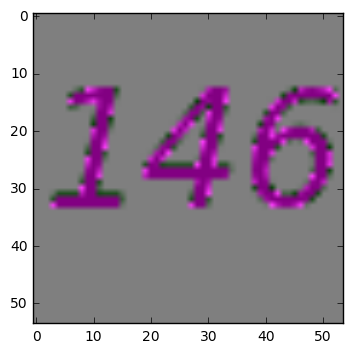

In [20]:
print(synthetic_train_labels[10])

%matplotlib inline
plt.figure()
plt.imshow(synthetic_train_dataset[10]);
plt.show

In [21]:
train_dataset_file = open(synthetic_data_directory+'synthetic_train_dataset.pickle','r')
source_train_dataset = pickle.load(train_dataset_file)

train_labels_file = open(synthetic_data_directory+'synthetic_train_labels.pickle','r')
source_train_labels = np.asarray(pickle.load(train_labels_file))

test_dataset_file = open(synthetic_data_directory+'synthetic_test_dataset.pickle','r')
test_dataset = pickle.load(test_dataset_file)

test_labels_file = open(synthetic_data_directory+'synthetic_test_labels.pickle','r')
test_labels_1 = np.asarray(pickle.load(test_labels_file))

trainlen = int(0.8 * len(source_train_dataset))

valid_dataset = source_train_dataset[trainlen:,:,:,:]
valid_labels_1 = source_train_labels[trainlen:]

train_dataset = source_train_dataset[:trainlen,:,:,:]
train_labels_1 = source_train_labels[:trainlen]

train_dataset_save = train_dataset
train_labels_save = train_labels_1
valid_dataset_save = valid_dataset
valid_labels_save = valid_labels_1
test_dataset_save = test_dataset
test_labels_save = test_labels_1

In [22]:
directory

'/home/hanu/dataset/svhn/f1/'

In [23]:
pickle_file = os.path.join(directory,'SVHN_synthetic.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset_save,
    'train_labels': train_labels_save,
    'valid_dataset': valid_dataset_save,
    'valid_labels': valid_labels_save,
    'test_dataset': test_dataset_save,
    'test_labels': test_labels_save,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

('Compressed pickle size:', 1750000516)


In [26]:
#train_dataset_file = open(temp_directory+'train_dataset.pickle','r')
train_dataset_file = open('/home/hanu/dataset/svhn/f1/synthetic_datasynthetic_train_dataset.pickle','r')
source_train_dataset = pickle.load(train_dataset_file)

#train_labels_file = open(temp_directory+'train_labels.pickle','r')
train_labels_file = open('/home/hanu/dataset/svhn/f1/synthetic_datasynthetic_test_dataset.pickle','r')
source_train_labels = np.asarray(pickle.load(train_labels_file))

#test_dataset_file = open(temp_directory+'test_dataset.pickle','r')
test_dataset_file = open('/home/hanu/dataset/svhn/f1/synthetic_datasynthetic_test_dataset.pickle','r')
test_dataset = pickle.load(test_dataset_file)

#test_labels_file = open(temp_directory+'test_labels.pickle','r')
test_labels_file = open('/home/hanu/dataset/svhn/f1/synthetic_datasynthetic_test_labels.pickle','r')
test_labels_1 = np.asarray(pickle.load(test_labels_file))

trainlen = int(0.8 * len(source_train_dataset))

valid_dataset = source_train_dataset[trainlen:,:,:,:]
valid_labels_1 = source_train_labels[trainlen:]

train_dataset = source_train_dataset[:trainlen,:,:,:]
train_labels_1 = source_train_labels[:trainlen]

train_dataset_save = train_dataset
train_labels_save = train_labels_1
valid_dataset_save = valid_dataset
valid_labels_save = valid_labels_1
test_dataset_save = test_dataset
test_labels_save = test_labels_1

In [30]:
pickle_file = os.path.join(directory,'SVHN_real.pickle') 

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset_save,
    'train_labels': train_labels_save,
    'valid_dataset': valid_dataset_save,
    'valid_labels': valid_labels_save,
    'test_dataset': test_dataset_save,
    'test_labels': test_labels_save,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 2274600526


# 2

In [28]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import logging
import os
import sys

import time
from datetime import timedelta
import prettytensor as pt

In [29]:
print(tf.__version__)
print(sys.version)

0.10.0rc0
2.7.12 |Anaconda 4.2.0 (64-bit)| (default, Jul  2 2016, 17:42:40) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [31]:
pickle_file = os.path.join(directory,'SVHN_real.pickle') 

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (28000, 54, 54, 3) (15000, 54, 54, 3)
Validation set (7000, 54, 54, 3) (0, 54, 54, 3)
Test set (15000, 54, 54, 3) (15000,)


In [32]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = cls_true[i]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = cls_pred[i]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

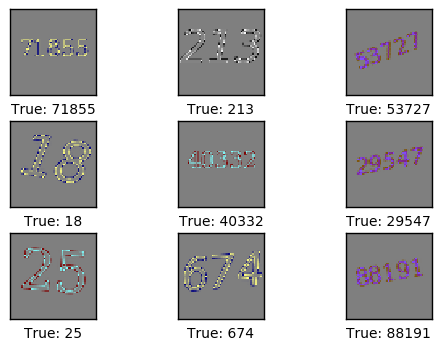

In [33]:
# Get the first images from the test-set.
images = test_dataset[0:9]

# Get the true classes for those images.
cls_true = test_labels[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)

In [34]:
# Helper function for getting the nth digit from an integer
# For example nth_digit(2534,2) = 5

def nth_digit(number,n):
    l = len(str(number))
    if l >= n:
        return int(str(number)[n-1])
    else:
        return 10

In [41]:
image_size = 54
num_labels = 11
num_channels = 3

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)

    # get the number of digits in the house number, e.g. 218 has labels_num_length=3
    labels_num_length = np.asarray(map(lambda x:len(str(x)), labels))

    # get the individual digits from the house number, 10 mean blank
    # For example label digits for the number 218 are: [2,1,8,10,10] 
    labels_digit1 = np.asarray(map(lambda x:nth_digit(x,1), labels))
    labels_digit2 = np.asarray(map(lambda x:nth_digit(x,2), labels))
    labels_digit3 = np.asarray(map(lambda x:nth_digit(x,3), labels))
    labels_digit4 = np.asarray(map(lambda x:nth_digit(x,4), labels))
    labels_digit5 = np.asarray(map(lambda x:nth_digit(x,5), labels))

    # Turn the labels above into 1-hot encodings
    labels_num_length = (np.arange(num_labels) == labels_num_length[:,None]).astype(np.int32)
    labels_digit1 = (np.arange(num_labels) == labels_digit1[:,None]).astype(np.int32)
    labels_digit2 = (np.arange(num_labels) == labels_digit2[:,None]).astype(np.int32)
    labels_digit3 = (np.arange(num_labels) == labels_digit3[:,None]).astype(np.int32)
    labels_digit4 = (np.arange(num_labels) == labels_digit4[:,None]).astype(np.int32)
    labels_digit5 = (np.arange(num_labels) == labels_digit5[:,None]).astype(np.int32)

    # Combine the individual 1-hot encodings into a single matrix
    labels_list = np.stack((labels_num_length, labels_digit1, labels_digit2, labels_digit3, labels_digit4, labels_digit5), axis=1)
    return dataset, labels_list

In [42]:
train_dataset, train_labels = reformat(train_dataset, train_labels)

ValueError: invalid literal for int() with base 10: '['

In [43]:
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)

In [44]:
test_dataset, test_labels = reformat(test_dataset, test_labels)

In [45]:


print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (28000, 54, 54, 3) (15000, 54, 54, 3)
Validation set (7000, 54, 54, 3) (0, 6, 11)
Test set (15000, 54, 54, 3) (15000, 6, 11)


In [36]:
print(test_labels[8]) # compare with the last example image above

88191


In [37]:
def ohe_to_housenumbers(ohe_labels):
    lengths = ohe_labels[:,0,:]
    digits1 = ohe_labels[:,1,:]
    digits2 = ohe_labels[:,2,:]
    digits3 = ohe_labels[:,3,:]
    digits4 = ohe_labels[:,4,:]
    digits5 = ohe_labels[:,5,:]
    
    num_labels = len(ohe_labels)
    housenumbers = np.zeros(shape=num_labels, dtype=np.int)
    
    for i in range(num_labels):
        l = np.argmax(lengths[i])
        d1 = np.argmax(digits1[i])
        d2 = np.argmax(digits2[i])
        d3 = np.argmax(digits3[i])
        d4 = np.argmax(digits4[i])
        d5 = np.argmax(digits5[i])
        d = str(d1)+str(d2)+str(d3)+str(d4)+str(d5)
        housenumbers[i] = int(d[:min(l,5)])
        
    return housenumbers
    

In [39]:
print(ohe_to_housenumbers(test_labels[:9])) # compare with example images above

IndexError: too many indices for array